# Background

Links:
- [Wikipedia](https://en.wikipedia.org/wiki/Frequentist_inference)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use("../style.mplstyle")

<AxesSubplot:ylabel='Count'>

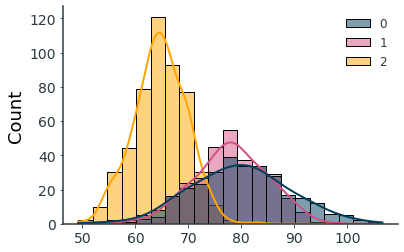

In [2]:
np.random.seed(123)
n1 = np.random.normal(80, 9, 300)
n2 = np.random.normal(78, 7, 300)
n3 = np.random.normal(65, 5, 500)

sns.histplot([n1, n2, n3], kde=True)

# Confidence Intervals

Standard Deviation:
$
\hat{\sigma}=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

Standard Error:
$
s_{e} = \frac {\hat{\sigma}}{\sqrt{n}}
$

In [3]:
n = n3
se = n.std() / np.sqrt(len(n))
mu = n.mean()

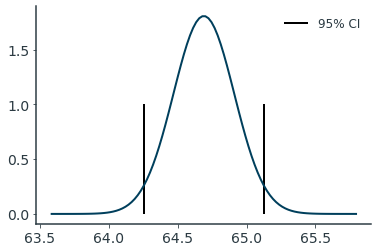

In [4]:
x = np.linspace(mu - 5 * se, mu + 5 * se, 100)
y = stats.norm.pdf(x, mu, se)
z = stats.norm.ppf(0.975)  # 95% CI
ci = (mu - z * se, mu + z * se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1, color="k")
plt.vlines(ci[0], ymin=0, ymax=1, color="k", label="95% CI")
plt.legend()
plt.show()

# Hypothesis Testing

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

<AxesSubplot:ylabel='Count'>

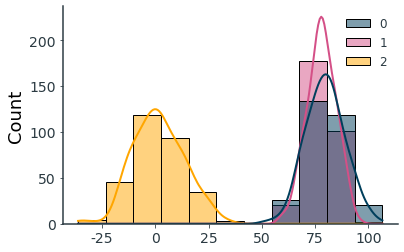

In [5]:
ndiff = n1 - n2

sns.histplot([n1, n2, ndiff], kde=True)


$
\mu_{diff} = \mu_1 + \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$


In [6]:
mu_diff = n1.mean() - n2.mean()
se_diff = np.sqrt(n1.var() / len(n1) + n2.var() / len(n2))

In [7]:
ci = (mu_diff - 1.96 * se_diff, mu_diff + 1.96 * se_diff)
ci  # 95% confidence difference between means of n1 and n2 lies within this range

(0.43036486590497014, 3.0323611583710104)

Z statistic:
$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

A measure of how extreme the observed differenceis, compared to the value we want to test against, $H_{0}$.

2.608


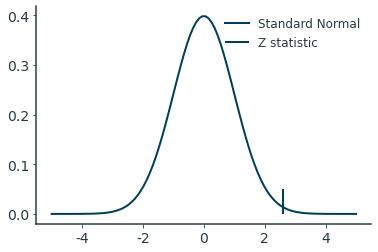

In [8]:
z = mu_diff / se_diff  # H0 = 0
print(f"{z:.3f}")
x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=0.05, label="Z statistic")
plt.legend()
plt.show()

Hypothesis tests are less conservative than checking if the 95% CI of two groups overlap - it's possible for CIs to overlap but to still have a statistically significiant difference.

In [9]:
cont_mu, cont_se = (71, 1)
test_mu, test_se = (74, 7)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se + cont_se)

print(
    f"Control 95% CI: ({cont_mu - 1.96 * cont_se:.2f}, {cont_mu + 1.96 * cont_se:.2f})"
)
print(
    f"Test 95% CI   : ({test_mu - 1.96 * test_se:.2f}, {test_mu + 1.96 * test_se:.2f})"
)
print(
    f"Diff 95% CI   : ({diff_mu - 1.96 * diff_se:.3f}, {diff_mu + 1.96 * diff_se:.3f})"
)

Control 95% CI: (69.04, 72.96)
Test 95% CI   : (60.28, 87.72)
Diff 95% CI   : (0.228, 5.772)


# P-values

"The p-value is the probability of obtaining results at least as extreme as the results actually observed during the test, assuming the null hypothesis is correct."

In [10]:
print(f"P-value: {stats.norm.cdf(z):.4f}")

P-value: 0.9955


In [11]:
diff_mu = n1.mean() - n2.mean()
diff_se = np.sqrt(n1.var() / len(n1) + n2.var() / len(n2))
print(
    f"95% CI  : ({diff_mu - stats.norm.ppf(.975)*diff_se:.2f}, {diff_mu + stats.norm.ppf(.975)*diff_se:.2f})"
)
print(
    f"99% CI  : ({diff_mu - stats.norm.ppf(.995)*diff_se:.2f}, {diff_mu + stats.norm.ppf(.995)*diff_se:.2f})"
)
print(
    f"99.9% CI: ({diff_mu - stats.norm.ppf(.9995)*diff_se:.2f}, {diff_mu + stats.norm.ppf(.9995)*diff_se:.2f})"
)

95% CI  : (0.43, 3.03)
99% CI  : (0.02, 3.44)
99.9% CI: (-0.45, 3.92)


# Combined

In [12]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))

    diff = mu1 - mu2
    se_diff = np.sqrt(test.var() / len(test) + control.var() / len(control))

    z_stats = (diff - h0) / se_diff
    p_value = stats.norm.cdf(z_stats)

    def critial(se):
        return -se * stats.norm.ppf((1 - confidence) / 2)

    print(f"Test {confidence*100:.1f}% CI        : {mu1:.2f} +- {critial(se1):.2f}")
    print(f"Control {confidence*100:.1f}% CI     : {mu2:.2f} +- {critial(se2):.2f}")
    print(f"Test-Control {confidence*100:.1f}% CI: {diff:.2f} +- {critial(se_diff):.2f}")
    print(f"Z Statistic          : {z_stats:.4f}")
    print(f"P-Value              : {p_value:.4f}")


AB_test(n1, n2)

Test 95.0% CI        : 79.74 +- 1.05
Control 95.0% CI     : 78.01 +- 0.77
Test-Control 95.0% CI: 1.73 +- 1.30
Z Statistic          : 2.6084
P-Value              : 0.9955
